# Simulation manip Celine Gabillet

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
matplotlib.rcParams['text.usetex'] = True
import copy
import os, sys
from string import Template
import time
from IPython.display import display
import scipy.optimize 
import scipy.stats

from trustutils import run 
from trustutils import visit
from trustutils.jupyter import plot

run.introduction("C. Reiss","")

run.TRUST_parameters()

## Introduction 
 Validation made by : C. Reiss



 Report generated 30/05/2023

### TRUST parameters 
 * Version TRUST: 1.9.2_beta
 * Binary used: /volatile/catB/cr268029/triocfd/TrioCFD_opt (built in directory /volatile/catB/cr268029/triocfd/share/Validation/Rapports_automatiques/Multiphase/CMFD/Gabillet/build)

In [2]:
## Hand-built diameter fields to give to TRUST

# Start of injection 1390
str_d0 = "1.e-6" # So there is something so the calculation launches ; no consequence as zero void fraction
str_d2 = "1.e-3*.3"
str_d5 = "1.e-3*((((.45+((x*1.e3-1390.)_MAX_0.)/250.)_MIN_(0.95))_MIN_(.2+y*150.))_MAX_.4)"
str_d10= "1.e-3*((((.90+((x*1.e3-1390.)_MAX_0.)/250.)_MIN_(1.45))_MIN_(.2+y*400.))_MAX_.5)"

In [3]:
## Calculate injection flux using experimental results and a mass balance

noms_debit= [0, 2, 5, 10]
noms_positions=['a', 'b', 'c']

y = np.linspace(0.025/2000, 0.025-0.025/2000, 1000)
y_sur_h = y/12.5e-3


tab_G = [ [0 for i in range(3)] for i in range(4)] # tab_G[debit air][position]

for pos in range(3):
    for deb in range(1, 4) :
        tab_G[deb][pos] = pd.read_csv(f"src/data/{noms_debit[deb]}{noms_positions[pos]}_G.txt", sep = '\t')
        tab_G[deb][pos].columns = ['y/h', 'alp_p', 'UG/Ulmax', 'alp', 'UG']


inj_flux_calc = [ [ 0. for j in range(3)] for i in range(4)]
debit_calc    = [ [ 0. for j in range(3)] for i in range(4)]

for i in range(1,4) :
    for j in range(3) :
        tab_y_loc = np.array(tab_G[i][j]['y/h'])*0.0125
        width_loc = np.append(
                        np.append([ tab_y_loc[0] + (tab_y_loc[1]-tab_y_loc[0])/2], 
                            (tab_y_loc[2:] - tab_y_loc[:-2])/2
                            ),
                        [tab_y_loc[-1]-tab_y_loc[-2]])
        debit_loc = width_loc*np.array(tab_G[i][j]['UG'])*np.array(tab_G[i][j]['alp'])
        debit_calc[i][j] = np.sum(debit_loc)

    inj_flux_calc[i][0] = debit_calc[i][0]/.031
    inj_flux_calc[i][1] = max((debit_calc[i][1]-debit_calc[i][0])/.062, 0)
    inj_flux_calc[i][2] = (debit_calc[i][2]-debit_calc[i][1])/.062


In [4]:
## Build entrance injection flux with injection defect to give to TRUST

flux_entree_air = inj_flux_calc 

str_flux_entree_air = ["0." for i in range(4)]

for i in range(1, 4):
    val_a  = (flux_entree_air[i][0]+flux_entree_air[i][1])/2. 
    val_b  = (flux_entree_air[i][1]+flux_entree_air[i][2])/2. 
    val_0a = str( (31.*flux_entree_air[i][0] - 10.* val_a/2. ) / 26. )
    val_ab = str( max((62.*flux_entree_air[i][1] - 10.* val_a/2. - 10.* val_b/2 ) / 52. , 0) )
    val_bc = str( (62.*flux_entree_air[i][2] - 10.* val_b/2. ) / 57. )

    val_a = str(val_a)
    val_b = str(val_b)
    
    str_flux_entree_air[i] += f"+(x<1.411)*{val_0a}"
    str_flux_entree_air[i] += f"+(x<1.421)*(x]1.411)*(({val_a}-{val_0a})*(x-1.411)/0.01+{val_0a})"
    str_flux_entree_air[i] += f"+(x<1.431)*(x]1.421)*(({val_ab}-{val_a})*(x-1.421)/0.01+{val_a})"
    str_flux_entree_air[i] += f"+(x<1.473)*(x]1.431)*({val_ab})"
    str_flux_entree_air[i] += f"+(x<1.483)*(x]1.473)*(({val_b}-{val_ab})*(x-1.473)/0.01+{val_ab})"
    str_flux_entree_air[i] += f"+(x<1.493)*(x]1.483)*(({val_bc}-{val_b})*(x-1.483)/0.01+{val_b})"
    str_flux_entree_air[i] += f"+(x]1.493)*({val_bc})"

    str_flux_entree_air[i] = f"({str_flux_entree_air[i]})"


In [5]:
def loadText(data, index_column=0, nb_column=-1, transpose=True, dtype="float", skiprows=0):
        
    if nb_column == -1:
        nb = None
    else:
        nb = index_column + nb_column

    try:
        if transpose:
            matrix = np.loadtxt(f'build/{data}', dtype=dtype, skiprows=skiprows).T[index_column:nb]
        else:
            matrix = np.loadtxt(data, dtype=dtype, skiprows=skiprows)[index_column:nb]
    except:
        if transpose:
            matrix = np.loadtxt(data, dtype=dtype, skiprows=skiprows).T
        else:
            matrix = np.loadtxt(data, dtype=dtype, skiprows=skiprows)
    return matrix


In [6]:
force_recalculation = False # if False, existing results will be used if the build directory exists, e.g. the trust-nk calculation will be skipped to quickly show results
number_of_partitions = 4


tab_x_pos = [1421, 1483, 1545]

schema = { "PolyMAC" : " PolyMAC_P0  dis  option_covimac {  } "}# , "VDF" : " VDF  dis  option_vdf { all_options } " }
tab_diam   = [str_d0,str_d2,str_d5,str_d10]

title_raf  = [    1 ]#,     2  ,  5  ]

ny         = [     20,     40 ,  100 ]

nx1        = [    51,    101 , 201 ]
nx2        = [    61,     81 , 161 ]
nx3        = [    21,     41 ,  81 ]

u_0        = 1.16

beta_lift_disp =  {"Off" : 0}#,  "On" : 1}
Wl_u = { "Single_phase" : "adaptative { } "}#, "Ramstorfer" : "ramstorfer { } "}
      
def GenerateInputFile(name,substitutions_dict):
    with open(f"build/jdd.data", "r") as file: 
        filedata = Template(file.read())
    result = filedata.substitute(substitutions_dict)
    with open(f"build/{name}.data", "w") as file:
        file.write(result)


if force_recalculation or not os.path.exists('build'):
    print('Recalculation running..')
    run.reset()
    # Trigger the deletion of build directory and copy of all files inside the src directory into a new build directory:
    run.defaultSuite_ = run.TRUSTSuite(runPrepare=False)

    for r in range(len(title_raf)) :
        for inj in range(len(noms_debit)) :
            for sc in schema.keys():
                for b in  beta_lift_disp.keys() :
                    for wl in Wl_u.keys():
                        name = f"inj_{noms_debit[inj]}mms_{sc}_LiftDisp{b}_WallLaw{wl}_raf_{title_raf[r]}"
                        print(name)
                        os.system(f'mkdir build/{name}') 
                        substitutions_dict = {  "schema" : schema[sc],
                                                "WLu" : Wl_u[wl],
                                                "ny"  : str(ny[r]),
                                                "nx1" : str(nx1[r]),
                                                "nx2" : str(nx2[r]),
                                                "nx3" : str(nx3[r]),
                                                "diametre_bulles" : tab_diam[inj] ,
                                                "flux_entree_air" : str_flux_entree_air[inj],
                                                "beta_disp" : beta_lift_disp[b] ,
                                                "beta_lift" : beta_lift_disp[b] ,
                                                "y0_sonde" : 0.025/(2*ny[r]),
                                                "y1_sonde" : 0.025-0.025/(2*ny[r])
                                                }
                        GenerateInputFile(name,substitutions_dict)
                        if number_of_partitions == 1:
                            run.addCase(".", f"{name}.data")
                        else:
                            os.system(f'mv build/{name}.data build/{name} ; cd build/{name};  make_PAR.data {name} {number_of_partitions}; cd ../..')
                            run.addCase(f"./{name}", f"PAR_{name}.data",nbProcs=number_of_partitions)
    run.runCases()
    display(run.tablePerf())

else:
    print('No recalculation, reusing old results!')

No recalculation, reusing old results!


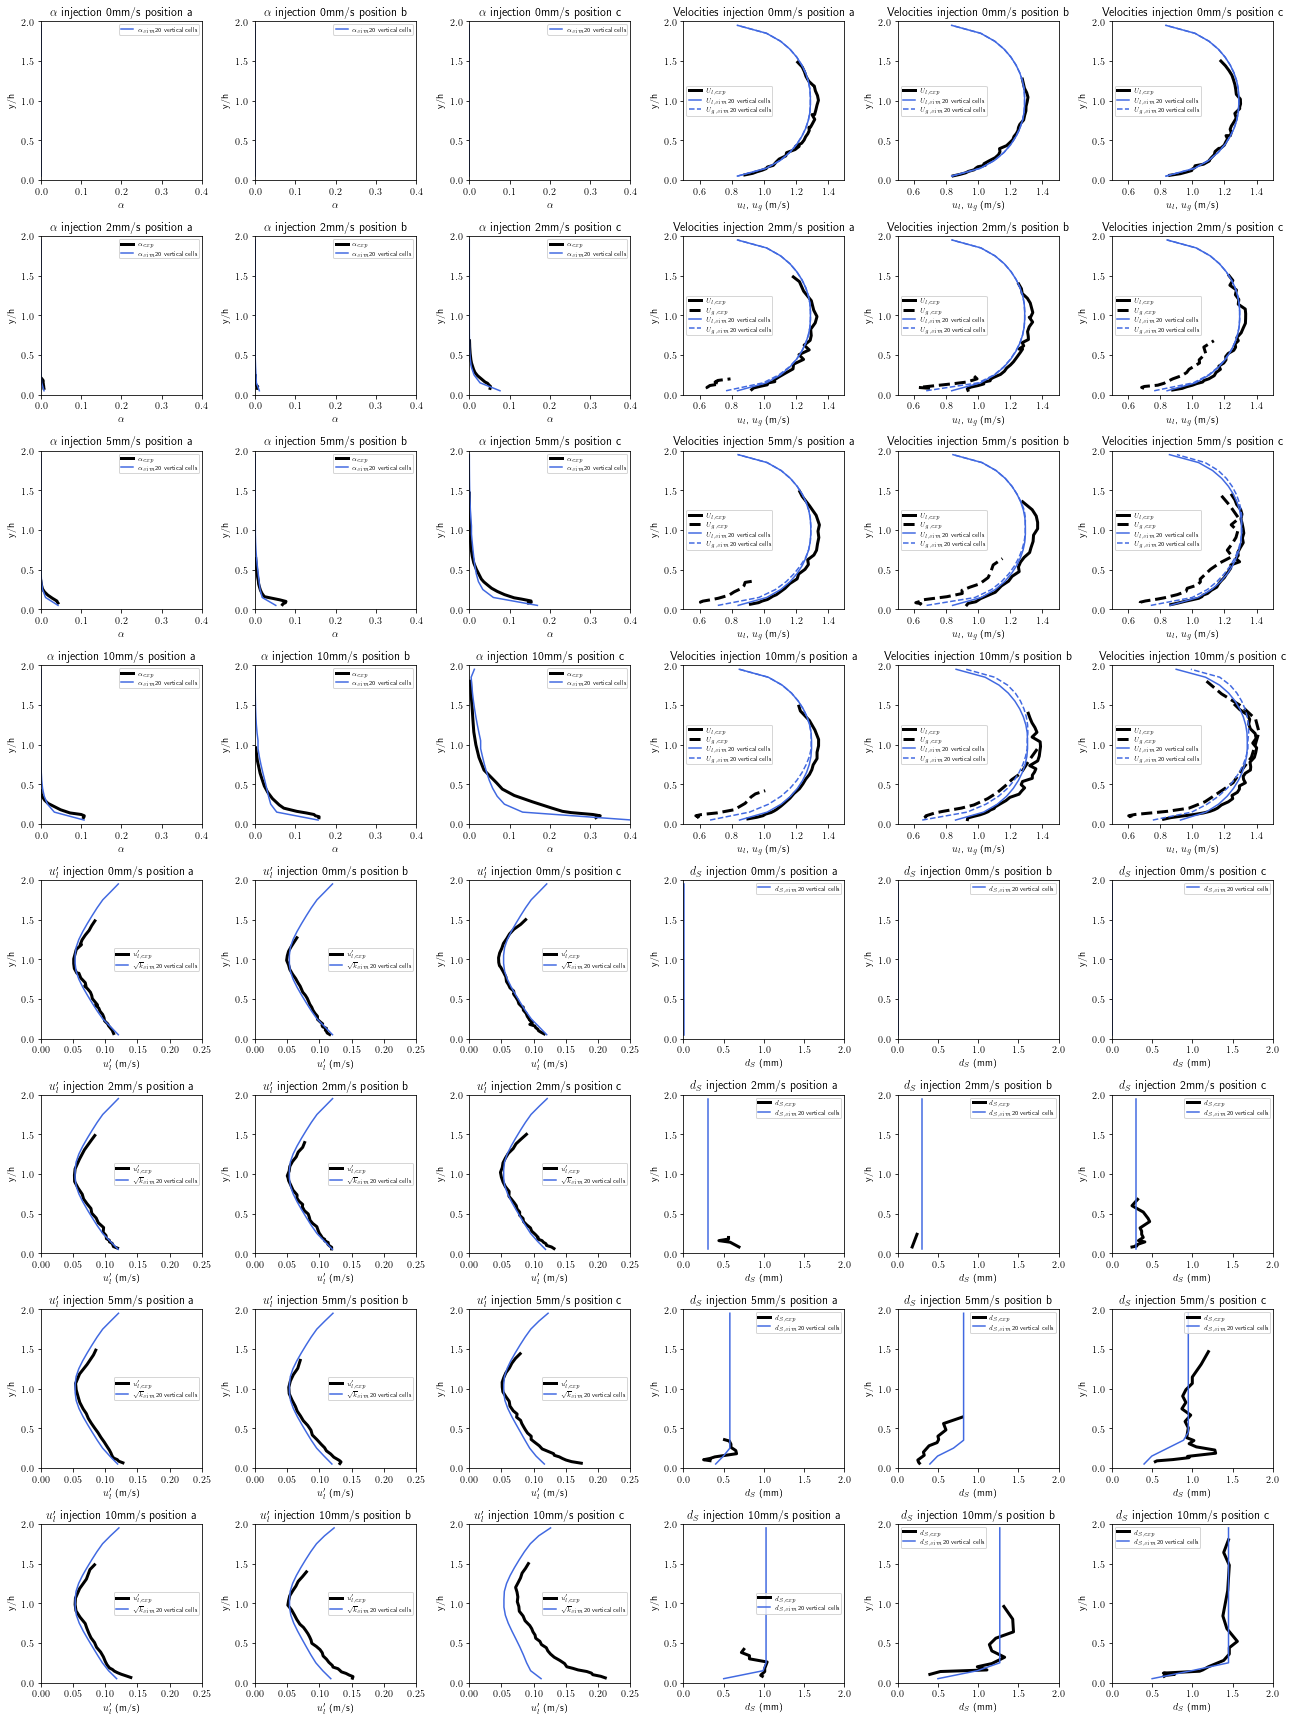

In [19]:
t_mesure=-1
color_raf  = ["royalblue", "chartreuse", "orange"]

for sc in schema.keys():
    for b in  beta_lift_disp.keys() :
        for wl in Wl_u.keys():
            name_file = f"{sc}_LiftDisp{b}_WallLaw{wl}"
            fig = plt.figure(figsize=(6*3, 8*3))
            axs = fig.subplots(8,6)
            for iinj, inj in enumerate(noms_debit) :
                for ipos, pos in enumerate(noms_positions) :
                    liqExp = pd.read_csv(f"src/data/{inj}{pos}_L.txt", sep = '\t')
                    liqExp.columns=['y/h', 'UL/Ulmax', 'uL/ULmax', 'UL', 'uL']
                    axs[iinj, 3+ipos].plot( liqExp['UL'], liqExp['y/h'], 'k-', linewidth = 3, label = r"$U_{l,exp}$")
                    axs[4+iinj, ipos].plot( liqExp['uL'], liqExp['y/h'], 'k-', linewidth = 3, label = r"$u'_{l,exp}$")

                    if os.path.exists(f"src/data/{inj}{pos}_G.txt") :
                        gasExp = pd.read_csv(f"src/data/{inj}{pos}_G.txt", sep = '\t')
                        gasExp.columns = ['y/h', 'alp_p', 'UG/Ulmax', 'alp', 'UG']
                        axs[iinj, ipos].plot(gasExp['alp'], gasExp['y/h'], 'k-', linewidth = 3, label = r"$\alpha_{exp}$")
                        axs[iinj, 3+ipos].plot( gasExp['UG'], gasExp['y/h'], 'k--', linewidth = 3, label = r"$U_{g,exp}$")

                    if os.path.exists(f"src/data/{inj}{pos}_B.txt") :
                        bubExp = pd.read_csv(f"src/data/{inj}{pos}_B.txt", sep = '\t')
                        axs[4+iinj, 3+ipos].plot( bubExp['DB']*1000, bubExp['y/h'], 'k-', linewidth = 3, label = r"$d_{S,exp}$")

                    for r in range(len(title_raf)) :
                        y_h = np.linspace( 2/(2*ny[r]), 2-2/(2*ny[r]),  ny[r]) 
                        name = f"inj_{inj}mms_{sc}_LiftDisp{b}_WallLaw{wl}_raf_{title_raf[r]}"

                        alphaSim=np.array(loadText(f"build/{name}/PAR_{name}_ALPHA_AIR_{pos.upper()}.son"))[1::,-1]
                        axs[iinj, ipos].plot(alphaSim, y_h, '-', color = color_raf[r], label = r"$\alpha_{sim}$" + f"{ny[r]} vertical cells")

                        UlSim=np.array(loadText(f"build/{name}/PAR_{name}_VITESSE_EAU_{pos.upper()}.son"))[1::2,-1]
                        UgSim=np.array(loadText(f"build/{name}/PAR_{name}_VITESSE_AIR_{pos.upper()}.son"))[1::2,-1]
                        axs[iinj, 3+ipos].plot( UlSim, y_h, '-', color = color_raf[r], label = r"$U_{l,sim}$" + f"{ny[r]} vertical cells")
                        axs[iinj, 3+ipos].plot( UgSim, y_h, '--', color = color_raf[r], label = r"$U_{g,sim}$" + f"{ny[r]} vertical cells")

                        kSim=np.array(loadText(f"build/{name}/PAR_{name}_K_{pos.upper()}.son"))[1::,-1]
                        axs[4+iinj, ipos].plot( np.sqrt(kSim), y_h, '-', color = color_raf[r], label = r"$\sqrt{k}_{sim}$" + f"{ny[r]} vertical cells")

                        dbSim=np.array(loadText(f"build/{name}/PAR_{name}_DIAMETRE_{pos.upper()}.son"))[2::2,-1]
                        axs[4+iinj, 3+ipos].plot( dbSim*1000, y_h, '-', color = color_raf[r], label = r"$d_{S,sim}$" + f"{ny[r]} vertical cells")


                    for (i,j) in [(0,0),  (0,3), (4,0), (4,3)]:
                        axs[i+iinj, j+ipos].set_ylim(0,2)
                        axs[i+iinj, j+ipos].set_ylabel("y/h")
                        axs[i+iinj, j+ipos].legend(fontsize=6)

                    axs[iinj, ipos].set_xlim(-.0,.4)
                    axs[iinj, ipos].set_xlabel(r"$\alpha$")
                    axs[iinj, ipos].set_title(r"$\alpha$" + f" injection {inj}mm/s position {pos}")
                    axs[iinj, 3+ipos].set_xlim(.5, 1.5)
                    axs[iinj, 3+ipos].set_xlabel(r"$u_l$,  $u_g$ (m/s)")
                    axs[iinj, 3+ipos].set_title(f"Velocities injection {inj}mm/s position {pos}")
                    axs[4+iinj, ipos].set_xlim(0,.25)
                    axs[4+iinj, ipos].set_xlabel(r"$u_l'$ (m/s)")
                    axs[4+iinj, ipos].set_title(r"$u_l'$" + f" injection {inj}mm/s position {pos}")
                    axs[4+iinj, 3+ipos].set_xlim(0,2)
                    axs[4+iinj, 3+ipos].set_xlabel(r"$d_S$ (mm)")
                    axs[4+iinj, 3+ipos].set_title(r"$d_S$" + f" injection {inj}mm/s position {pos}")

            fig.tight_layout()
            fig.savefig(f"{name_file}.pdf")
